In [1]:
# 라이브러리 추가
import urllib.request
import json
import pandas as pd
import seaborn as sns; sns.set(style='darkgrid', font='KoPubDotum', font_scale=1.5)
import matplotlib.pyplot as plt

In [2]:
# 데이터랩 API를 이용한 검색량 조회 함수(최대 5개)
def datalab_api(keywords):

    # 데이터랩 API
    client_id = "89L30Y3xCshEctCoab1v"
    client_secret = "aIoL3WXAsj"

    url = "https://openapi.naver.com/v1/datalab/search"

    body = {
        "startDate":"2016-01-01",
        "endDate":"2019-06-30",
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    body = json.dumps(body)

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 데이터프레임
    df1 = pd.DataFrame(json_obj['results'][0]['data']); df1.columns=['기간', str(keywords[0])]
    df2 = pd.DataFrame(json_obj['results'][1]['data']); df2.columns=['기간', str(keywords[1])]
    df3 = pd.DataFrame(json_obj['results'][2]['data']); df3.columns=['기간', str(keywords[2])]
    df4 = pd.DataFrame(json_obj['results'][3]['data']); df4.columns=['기간', str(keywords[3])]
    df5 = pd.DataFrame(json_obj['results'][4]['data']); df5.columns=['기간', str(keywords[4])]
    
    # 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)
    
    return df5

In [3]:
# 최소-최대 정규화를 적용한 데이터랩 검색량 조회 함수 (무제한)
def datalab_api_kw_list(kw_list):

    # df: '국립공원' 검색량 최소값, 최대값
    df = datalab_api(kw_list[0]+kw_list[1])
    a, b = df.iloc[:,1].min(), df.iloc[:,1].max()

    i=2
    while i < len(kw_list):
        df1 = datalab_api(kw_list[0]+kw_list[i])
        # df1: 국립공원 컬럼의 최소값, 최대값
        x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()
        # 최소-최대 정규화
        df1.iloc[:,2] = (df1.iloc[:,2] - x) / (y - x) * (b - a) + a
        df1.iloc[:,3] = (df1.iloc[:,3] - x) / (y - x) * (b - a) + a
        df1.iloc[:,4] = (df1.iloc[:,4] - x) / (y - x) * (b - a) + a
        df1.iloc[:,5] = (df1.iloc[:,5] - x) / (y - x) * (b - a) + a
        df1 = df1.drop(columns=['기간', '국립공원'])
        df = pd.concat([df, df1], axis=1)
        i+=1
    
    # '테스트' 검색량 삭제
    df = df[df.columns.drop(list(df.filter(regex='테스트')))]
    
    return df

In [4]:
# 키워드 리스트
kw_list = [['국립공원'], ['국립공원관리공단', '국립공원공단', '테스트', '테스트']]

In [5]:
df = datalab_api_kw_list(kw_list)
df.to_excel('D:/GEODATA/RSRCH01.xlsx')
df.head()

,기간,국립공원,국립공원관리공단,국립공원공단
0,2016-01-01,1.13815,2.17093,0.0
1,2016-01-02,1.09951,2.04447,0.0
2,2016-01-03,1.02574,2.05501,0.0
3,2016-01-04,1.66859,5.02336,0.0
4,2016-01-05,1.36298,3.78684,0.0


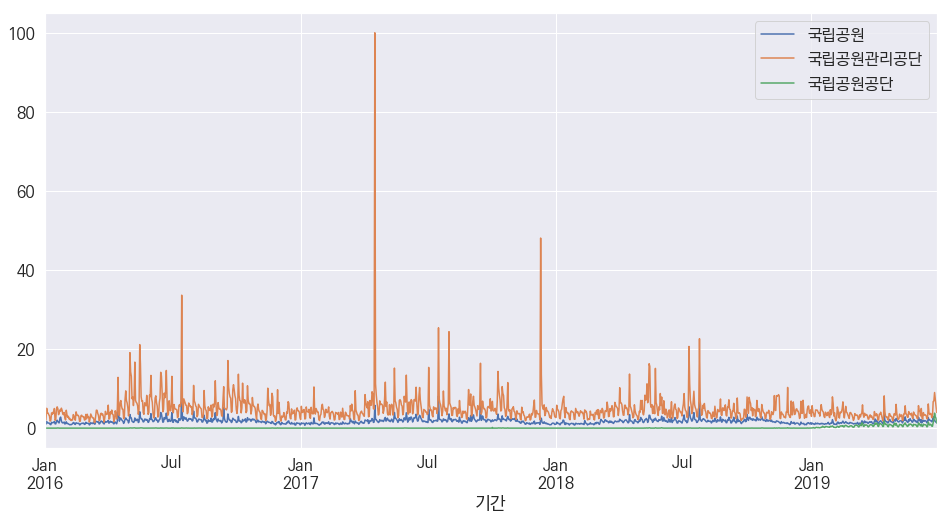

In [6]:
# '국립공원', '국립공원관리공단' '국립공원공단' 검색량 라인 플롯
df = pd.read_excel('D:/GEODATA/RSRCH01.xlsx', sheet_name='Sheet1' ,index_col='기간', parse_dates=True).drop(['Unnamed: 0'], axis=1)
df.plot(figsize=(16, 8))
plt.savefig('D:/GEODATA/IMG01.png', bbox_inches='tight')

In [7]:
# 연평균
df.groupby(df.index.year).mean()

,국립공원,국립공원관리공단,국립공원공단
기간,,,
2016,1.802936,5.135248,0.005892
2017,1.796606,5.313304,0.003801
2018,1.730333,4.637155,0.005774
2019,1.542190,3.586468,0.679952


In [8]:
print('국립공원 검색량: ' + format(df.mean()['국립공원'], ".2f"))
print('국립공원관리공단 검색량: ' + format(df.mean()['국립공원관리공단'], ".2f"))
print('국립공원관리공단 검색량: ' + format(df.mean()['국립공원관리공단'] / df.mean()['국립공원'], ".2f") + '배')
print('국립공원공단 검색량: ' + format(df.mean()['국립공원공단'], ".2f"))
print('국립공원공단 검색량: ' + format(df.mean()['국립공원공단'] / df.mean()['국립공원'], ".2f") + '배')

국립공원 검색량: 1.74
국립공원관리공단 검색량: 4.82
국립공원관리공단 검색량: 2.77배
국립공원공단 검색량: 0.10
국립공원공단 검색량: 0.06배


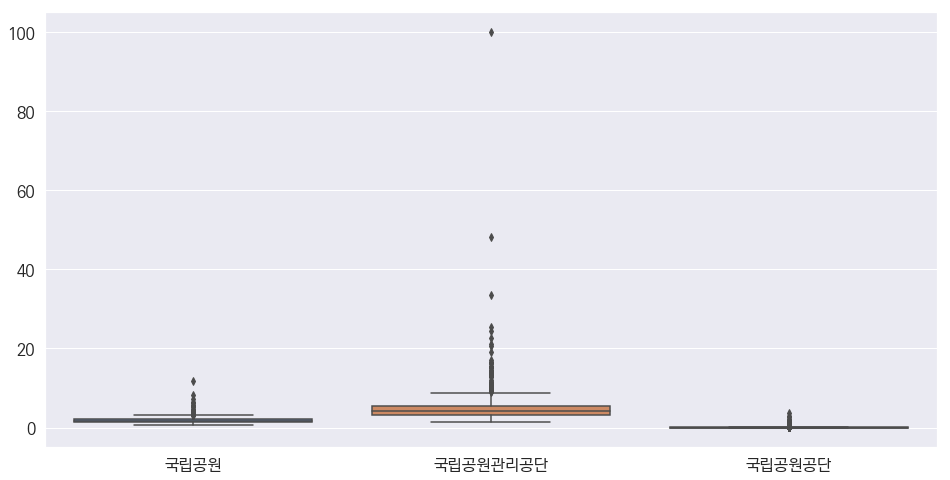

In [9]:
# '국립공원'과 '깃대종' 검색량 박스 플롯
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['국립공원', '국립공원관리공단', '국립공원공단']])
plt.savefig('D:/GEODATA/IMG02.png', bbox_inches='tight')

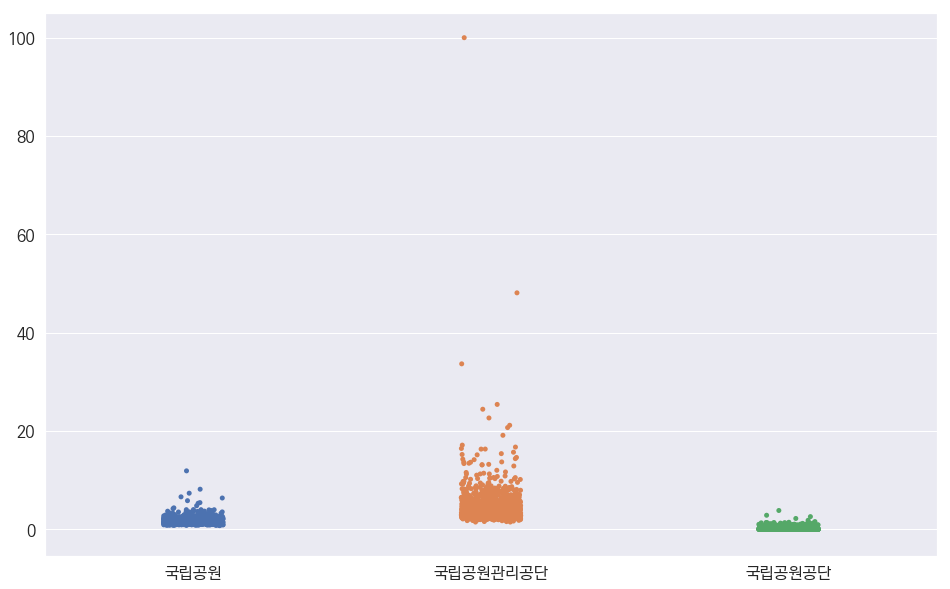

In [10]:
# '국립공원', '국립공원관리공단', '국립공원공단' 닷 플롯
plt.figure(figsize=(16, 10))
sns.stripplot(data=df[['국립공원', '국립공원관리공단', '국립공원공단']])
plt.savefig('D:/GEODATA/IMG03.png', bbox_inches='tight')

In [11]:
# 퍼센트 변화
df.groupby(df.index.year).mean().pct_change()*100

,국립공원,국립공원관리공단,국립공원공단
기간,,,
2016,NaN,NaN,NaN
2017,-0.351093,3.467336,-35.492857
2018,-3.688763,-12.725594,51.905541
2019,-10.873248,-22.658000,11677.057204


In [12]:
# 최근 4년간 퍼센트 변화
df.groupby(df.index.year).mean().iloc[[0, 3],:].pct_change()*100

,국립공원,국립공원관리공단,국립공원공단
기간,,,
2016,NaN,NaN,NaN
2019,-14.462298,-30.159785,11440.329509


In [13]:
# 피어슨 상관계수
print('국립공원관리공단 상관계수: ' + format(df.corrwith(df['국립공원'], method='pearson')['국립공원관리공단'], ".2f"))
print('국립공원공단 상관계수: ' + format(df.corrwith(df['국립공원'], method='pearson')['국립공원공단'], ".2f"))

국립공원관리공단 상관계수: 0.64
국립공원공단 상관계수: 0.01


In [14]:
# 연월평균 검색량
df['Year'] = df.index.year; df['Month'] = df.index.month
df = df.groupby(by=[df.index.year, df.index.month]).mean()

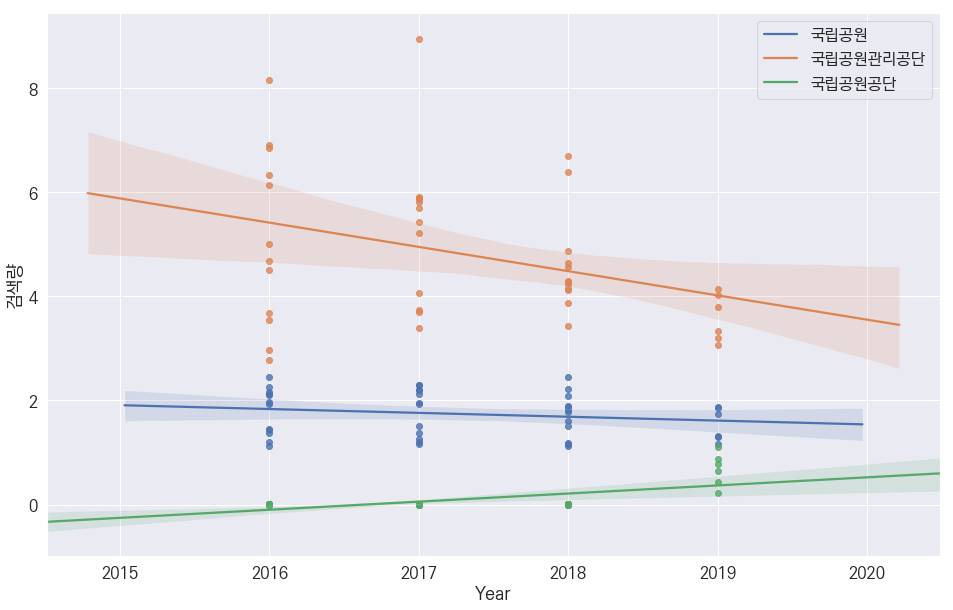

In [15]:
# '국립공원', '국립공원관리공단', '국립공원공단'검색량 회귀 플롯
plt.figure(figsize=(16, 10))
sns.regplot(x=df['Year'], y=df['국립공원'], data=df, order=1)
sns.regplot(x=df['Year'], y=df['국립공원관리공단'], data=df, order=1)
sns.regplot(x=df['Year'], y=df['국립공원공단'], data=df, order=1)
plt.ylabel('검색량')
plt.legend(labels=['국립공원', '국립공원관리공단', '국립공원공단'])
plt.savefig('D:/GEODATA/IMG08.png', bbox_inches='tight')
plt.show()

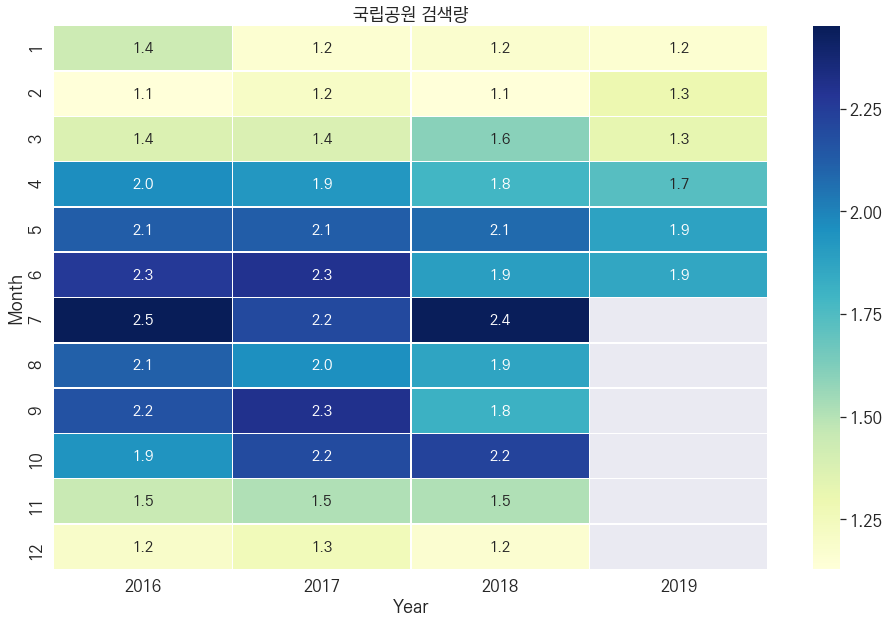

In [16]:
# '국립공원' 열지도
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df.pivot("Month", "Year", "국립공원"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
ax.set_title('국립공원 검색량')
plt.savefig('D:/GEODATA/IMG04.png', bbox_inches='tight')

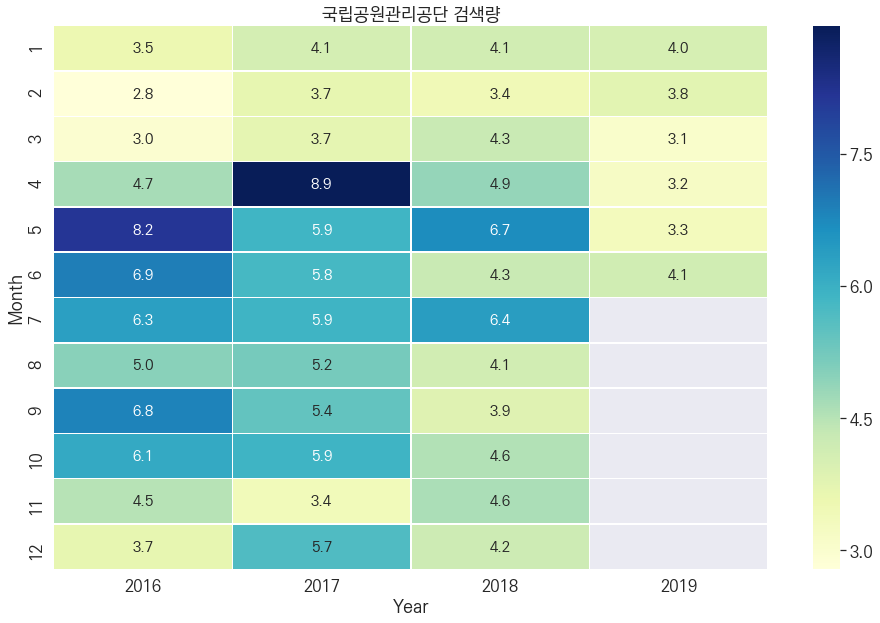

In [17]:
# '국립공원관리공단' 열지도
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df.pivot("Month", "Year", "국립공원관리공단"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
ax.set_title('국립공원관리공단 검색량')
plt.savefig('D:/GEODATA/IMG05.png', bbox_inches='tight')

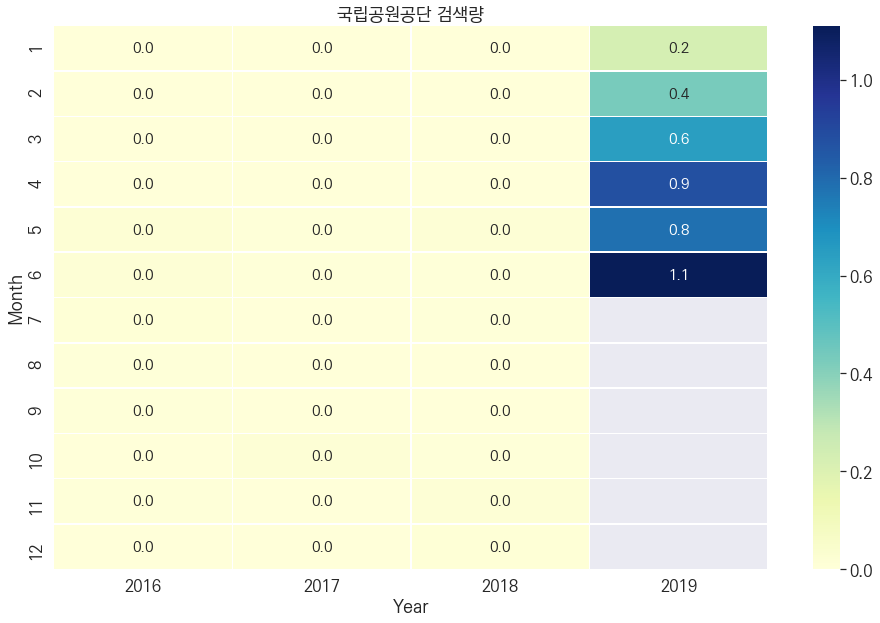

In [18]:
# '국립공원공단' 열지도
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df.pivot("Month", "Year", "국립공원공단"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
ax.set_title('국립공원공단 검색량')
plt.savefig('D:/GEODATA/IMG06.png', bbox_inches='tight')

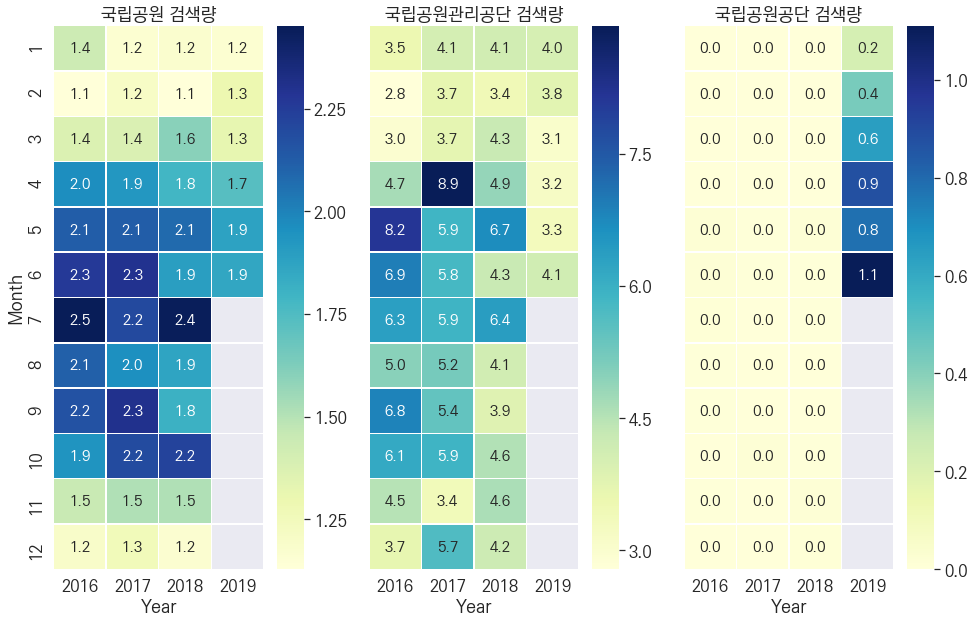

In [19]:
# '국립공원', '국립공원관리공단', '국립공원공단'검색량 열지도
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
sns.heatmap(df.pivot("Month", "Year", "국립공원"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
sns.heatmap(df.pivot("Month", "Year", "국립공원관리공단"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)
sns.heatmap(df.pivot("Month", "Year", "국립공원공단"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax3)

ax1.set_title('국립공원 검색량')
ax2.set_title('국립공원관리공단 검색량')
ax2.set_yticklabels([]); ax2.set_ylabel("")
ax3.set_title('국립공원공단 검색량')
ax3.set_yticklabels([]); ax3.set_ylabel("")
plt.savefig('D:/GEODATA/IMG07.png', bbox_inches='tight')

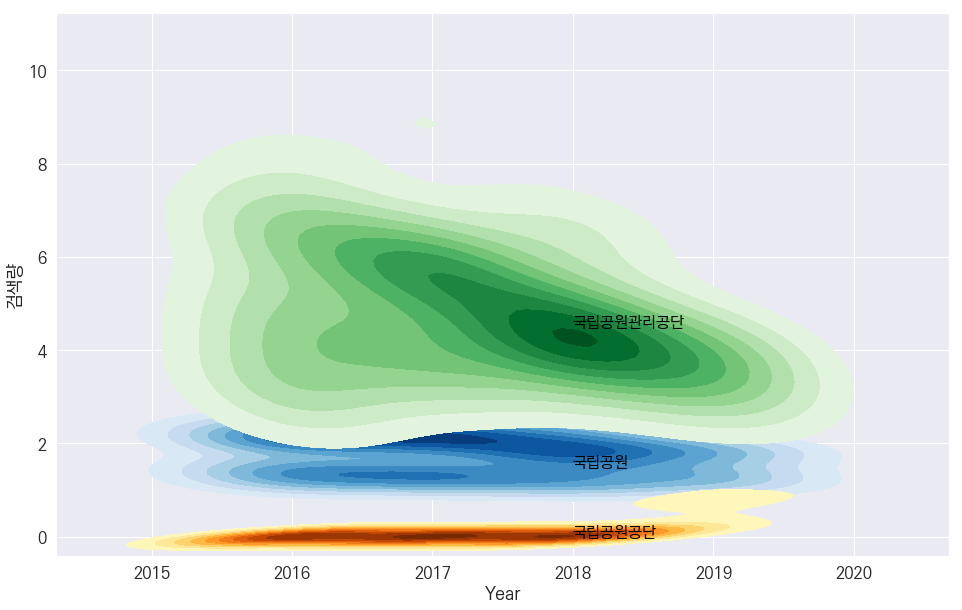

In [34]:
# '국립공원', '국립공원관리공단' KDE 플롯
# Draw the two density plots
f, ax = plt.subplots(figsize=(16, 10))
sns.kdeplot(df['Year'], df['국립공원'], cmap="Blues", shade=True, shade_lowest=False)
sns.kdeplot(df['Year'], df['국립공원관리공단'], cmap="Greens", shade=True, shade_lowest=False)
sns.kdeplot(df['Year'], df['국립공원공단'], cmap="YlOrBr", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2018, 1.5, "국립공원", size=16, color='black')
ax.text(2018, 4.5, "국립공원관리공단", size=16, color='black')
ax.text(2018, 0.0, "국립공원공단", size=16, color='black')
plt.ylabel('검색량')
plt.savefig('D:/GEODATA/IMG09.png', bbox_inches='tight')
plt.show()